In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import  mean_squared_error, r2_score

import statsmodels.api as sm

In [264]:
cal = pd.read_csv('calendar.csv.gz')
listd = pd.read_csv('listings.csv.gz')
lists = pd.read_csv('listings.csv')
revs = pd.read_csv('reviews.csv.gz')
nhood = pd.read_csv('neighbourhoods.csv')
purelst = pd.read_csv('listings.csv.gz')

In [265]:
# pd.set_option('display.max_colu?mns', 96)
pd.set_option('display.max_rows', 96)

In [266]:
#CLEANUP incoming dataframes

listd_drop_cols = ['scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','xl_picture_url',\
                   'host_name','host_location','neighbourhood_group_cleansed','square_feet',\
                   'maximum_nights','is_business_travel_ready']

# listd_numc_cols
# listd_catz_cols

print(len(listd.columns), len(listd_drop_cols))
listd.drop(listd_drop_cols,axis=1,inplace=True )
print(len(listd.columns), len(listd_drop_cols))

96 12
84 12


# ALL TRANSFORMATIONS FUNCTIONS  : 

In [267]:
print(cal.date.min(),cal.date.max())
print(revs.date.min(),revs.date.max())
# print(lists.last_review.min(),lists.last_review.max())

2018-07-05 2019-07-04
2009-05-03 2018-07-05


In [268]:
# tmp=listd.copy() # Create a new copy of the existing dataframe otherwise it is only by reference
# tmp.head().T

In [269]:
def price_xform(dframe,colname):
    dframe[colname]=dframe[colname].str.replace('$','')
    dframe[colname]=dframe[colname].str.replace(',','')
    dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [270]:
def cat_rename(dframe,colname,src,tgt):
    dframe[colname]=dframe[colname].str.replace(src,tgt)
#     dframe[colname]=dframe[colname].str.replace(',','')
#     dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [271]:
def create_dummies(dframe,colname):
#     dfnew=dframe.copy()
    dframe=pd.get_dummies(data=dframe, columns=[colname])# create dummies and drop the parent column
    dframe.drop(columns=[dframe.columns[-1]],inplace=True) #dropped the last column from the add dummies
    return dframe

In [272]:
#Impute Null Rows based on the specified column
def impute_nullrows(dframe,colname):
    print(dframe[colname].isnull().sum())
    dftmp=dframe[~dframe[colname].isnull()]   # remove nulls from one column
    print(dftmp[colname].isnull().sum())
    return dftmp


# TRANSFORM ACTIONS

In [273]:
# Convert to Booleans
listd['host_is_superhost'] = listd.apply(lambda x:  x.host_is_superhost=='t', axis= 1)
listd['host_has_profile_pic'] = listd.apply(lambda x:  x.host_has_profile_pic=='t', axis= 1)
listd['host_identity_verified'] = listd.apply(lambda x:  x.host_identity_verified=='t', axis= 1)
listd['instant_bookable'] = listd.apply(lambda x:  x.instant_bookable=='t', axis= 1)

In [274]:
#Transform all the price columns to remove "$" and ","

price_xform(listd,'price')
price_xform(listd,'weekly_price')
price_xform(listd,'monthly_price')
price_xform(listd,'security_deposit')
price_xform(listd,'cleaning_fee')
price_xform(listd,'extra_people')

In [275]:
#Transform the room_type . to create a meaningful name and create dummies

cat_rename(listd,'room_type','Entire home/apt','full')
cat_rename(listd,'room_type','Private room','pvt')
cat_rename(listd,'room_type','Shared room','shared')

listd=create_dummies(listd,'room_type')
# listd=pd.get_dummies(data=listd, columns=['room_type'])  # create dummies and drop the parent column
# listd.drop(columns=[listd.columns[-1]],inplace=True)  #dropped the last column from the add dummies

In [276]:
#Transform the bed_type . to create a meaningful name and create dummies
listd['bed_type'] = listd.apply(lambda x: x.bed_type=='Real Bed', axis=1)

In [277]:
#Put a count on amenities,   IF it does not work, pick the most important feature
listd['amentcnt'] =   listd.apply(lambda x: len(x.amenities.split(",")), axis=1)

In [278]:
#!!! APPLY the same for the test data also
#Impute the to remove the rows with no zipcode.  !!! APPLY the same for the test data also
listd=listd[~listd['zipcode'].isnull()]   # remove nulls from one column




In [279]:
#Impute the null values with meaningful data

listd['cleaning_fee']=listd['cleaning_fee'].fillna(0)
listd['review_scores_cleanliness'] = listd['review_scores_cleanliness'].fillna(listd.review_scores_cleanliness.mean())

listd['review_scores_location'] = listd['review_scores_location'].fillna(listd.review_scores_location.mean())
listd['review_scores_value'] = listd['review_scores_value'].fillna(listd.review_scores_value.mean())




In [280]:
# mask1 = listd['minimum_nights']>7 
# mask2 = listd['minimum_nights']<=32
# maskmid=mask1 & mask2 
# maskmid = (listd['minimum_nights']>7) & (listd['minimum_nights']<=32)
# mask2
# maskmid
listd.loc[listd['minimum_nights']<=7,'min_night_stay'] = 'short'
listd.loc[(listd['minimum_nights']>7) & (listd['minimum_nights']<=32),'min_night_stay'] = 'mid'
listd.loc[listd['minimum_nights']>32,'min_night_stay'] = 'long'
listd=create_dummies(listd,'min_night_stay')

In [281]:
#Condensing the property_type to sub categories

listd.loc[listd['property_type']=='Apartment', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Condominium', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guest suite', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Townhouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guesthouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Tiny house', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Timeshare', 'ppt_condensed'] = 'apt'

listd.loc[listd['property_type']=='Serviced apartment', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Bed and breakfast', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Treehouse', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Cabin', 'ppt_condensed'] = 'aptspl'

listd.loc[listd['property_type']=='Bus', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Boat', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Camper/RV', 'ppt_condensed'] = 'auto'

listd.loc[listd['property_type']=='Hostel', 'ppt_condensed'] = 'hostel'

listd.loc[listd['property_type']=='Boutique hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Resort', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Aparthotel', 'ppt_condensed'] = 'hotel'

listd.loc[listd['property_type']=='House', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Bungalow', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Cottage', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Villa', 'ppt_condensed'] = 'house'

listd.loc[listd['property_type']=='Other', 'ppt_condensed'] = 'other'

listd.loc[listd['property_type']=='Loft', 'ppt_condensed'] = 'room'

listd=create_dummies(listd,'ppt_condensed')

In [282]:
listd=create_dummies(listd,'zipcode')

In [283]:
#imputing some more missing values

listd['cleaning_fee'].fillna(0, inplace=True)
listd['beds'].fillna(0, inplace=True)
listd['bathrooms'].fillna(0, inplace=True)

In [284]:
# lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds',\
#              'bathrooms','guests_included','zipcode']

listd_drop_cols2=['id', 'listing_url', 'name', 'summary', 'space', 'description',\
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',\
       'house_rules', 'picture_url', 'host_id', 'host_url', 'host_since',\
       'host_about', 'host_response_time', 'host_response_rate',\
       'host_acceptance_rate', 'host_thumbnail_url',\
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',\
       'host_total_listings_count', 'host_verifications',\
       'host_has_profile_pic', 'street',\
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',\
       'market', 'smart_location', 'country_code', 'country', 'latitude',\
       'longitude', 'is_location_exact', 'property_type',\
       'amenities',\
       'weekly_price', 'monthly_price', 'security_deposit',\
       'extra_people', 'minimum_nights', 'calendar_updated',\
       'has_availability', 'availability_30', 'availability_60',\
       'availability_90', 'availability_365', 'calendar_last_scraped',\
       'number_of_reviews', 'first_review', 'last_review',\
       'review_scores_rating', 'review_scores_accuracy',\
       'review_scores_cleanliness', 'review_scores_checkin',\
       'review_scores_communication', 'review_scores_location',\
       'review_scores_value', 'requires_license', 'license',\
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',\
       'require_guest_profile_picture', 'require_guest_phone_verification',\
       'calculated_host_listings_count', 'reviews_per_month']
# listd_drop_cols2=['property_type','minimum_nights']
listd.drop(listd_drop_cols2,axis=1,inplace=True )

In [285]:
listd.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
       'guests_included', 'room_type_full', 'room_type_pvt', 'amentcnt',
       'min_night_stay_long', 'min_night_stay_mid', 'ppt_condensed_apt',
       'ppt_condensed_aptspl', 'ppt_condensed_auto', 'ppt_condensed_hostel',
       'ppt_condensed_hotel', 'ppt_condensed_house', 'ppt_condensed_other',
       'zipcode_94014.0', 'zipcode_94015.0', 'zipcode_94102.0',
       'zipcode_94103.0', 'zipcode_94104.0', 'zipcode_94105.0',
       'zipcode_94107.0', 'zipcode_94108.0', 'zipcode_94109.0',
       'zipcode_94110.0', 'zipcode_94111.0', 'zipcode_94112.0',
       'zipcode_94114.0', 'zipcode_94115.0', 'zipcode_94116.0',
       'zipcode_94117.0', 'zipcode_94118.0', 'zipcode_94121.0',
       'zipcode_94122.0', 'zipcode_94123.0', 'zipcode_94124.0',
       'zipcode_94127.0', 'zipcode_94129.0', 'zipcode_94131.0',
       'zipcode_94132.0', 'zipcode_94133.0

In [286]:
listd.shape

(4669, 50)

# EXTRA BEGIN

# EXTRA END

In [287]:
dfcorr=listd.corr()
# dfcorr.price.sort_values()


In [288]:
dfcorr.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,guests_included,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
host_is_superhost,1.000000,0.175279,-0.066246,-0.073244,-0.068472,-0.093756,-0.021697,-0.013003,-0.035032,0.004400,...,0.047449,-0.008327,-0.000980,0.016222,-0.012798,0.017896,-0.016272,-0.024038,-0.011413,-0.018776
host_identity_verified,0.175279,1.000000,0.022881,0.037757,0.083777,0.009490,-0.020877,0.057496,0.062758,0.043328,...,-0.004123,-0.026080,0.009686,0.000057,0.010770,0.014712,-0.018414,-0.054392,-0.035066,-0.024679
accommodates,-0.066246,0.022881,1.000000,0.480117,0.769191,0.834543,0.071087,0.434465,0.549483,0.559105,...,0.009334,0.023442,-0.009602,0.008477,0.019520,0.012934,-0.023730,0.001014,0.027702,0.004085
bathrooms,-0.073244,0.037757,0.480117,1.000000,0.554560,0.493639,0.036346,0.334613,0.376771,0.285099,...,-0.020438,0.037669,-0.014356,0.025868,-0.006674,0.002485,0.021276,-0.040516,-0.012096,0.003848
bedrooms,-0.068472,0.083777,0.769191,0.554560,1.000000,0.730330,0.046203,0.434527,0.581186,0.520352,...,-0.003992,0.037804,-0.023596,0.021624,0.009492,0.034685,-0.015172,0.012337,0.007095,0.001438


In [289]:
dfcorr.price.sort_values()

room_type_pvt            -0.255959
zipcode_94112.0          -0.081166
ppt_condensed_hostel     -0.065111
zipcode_94124.0          -0.058205
zipcode_94122.0          -0.046702
zipcode_94132.0          -0.043868
zipcode_94102.0          -0.043633
zipcode_94134.0          -0.037803
min_night_stay_mid       -0.037199
zipcode_94111.0          -0.027050
ppt_condensed_hotel      -0.026284
zipcode_94110.0          -0.025305
ppt_condensed_apt        -0.024605
zipcode_94014.0          -0.022688
ppt_condensed_aptspl     -0.020042
zipcode_94127.0          -0.018272
zipcode_94116.0          -0.015017
ppt_condensed_auto       -0.014007
ppt_condensed_other      -0.013178
host_is_superhost        -0.013003
zipcode_94015.0          -0.009239
zipcode_94107.0           0.001773
zipcode_94108.0           0.002104
zipcode_94118.0           0.002555
zipcode_94105.0           0.002993
zipcode_94131.0           0.003971
zipcode_94129.0           0.004267
zipcode_94158.0           0.006018
zipcode_94103.0     

'''
lreg_cols_master = ['square_feet','weekly_price','cleaning_fee','accommodates','bedrooms','beds','bathrooms','guests_included','zipcode']
lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds','bathrooms','guests_included','zipcode']
'''

In [290]:
dflreg = listd.copy()
dflreg = sm.add_constant(dflreg)

In [291]:
dflreg['host_is_superhost'] = (dflreg['host_is_superhost'] == True).astype(int)
dflreg['host_identity_verified'] = (dflreg['host_identity_verified'] == True).astype(int)
dflreg['bed_type'] = (dflreg['bed_type'] == True).astype(int)

In [292]:
dfscatter=dflreg.loc[:,'price':'guests_included']
dfscatter.head()

,price,cleaning_fee,guests_included
0,170.0,100.0,2
1,235.0,100.0,2
2,65.0,50.0,1
3,63.0,30.0,1
4,65.0,50.0,1


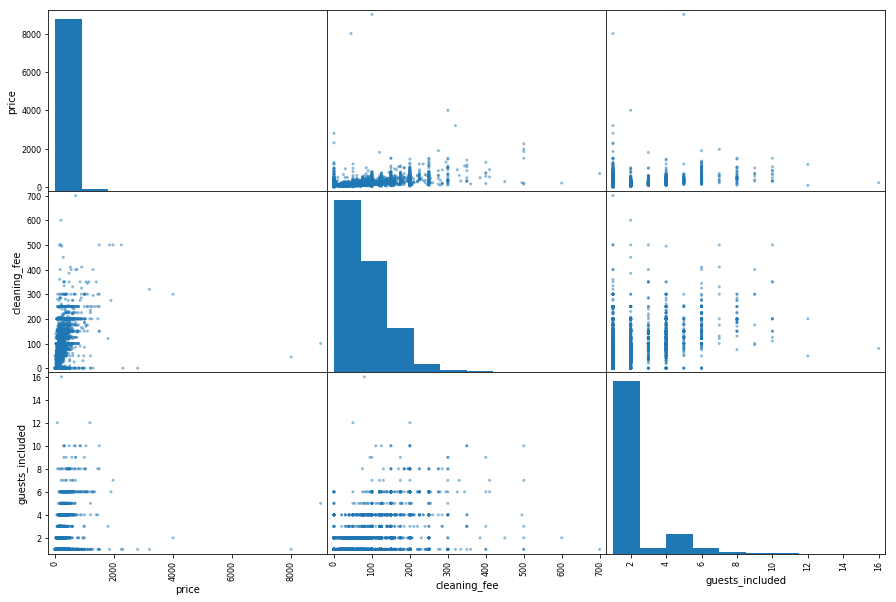

In [293]:
pd.plotting.scatter_matrix(dfscatter,figsize=(15,10));

In [294]:
listd_insig_cols = ['host_is_superhost','host_identity_verified','bed_type','guests_included','room_type_full',\
                    'room_type_pvt','amentcnt','ppt_condensed_apt','ppt_condensed_aptspl','ppt_condensed_auto',\
                    'ppt_condensed_hotel','ppt_condensed_other',\
                    'zipcode_94014.0', 'zipcode_94015.0', 'zipcode_94102.0',\
                    'zipcode_94103.0', 'zipcode_94104.0', 'zipcode_94105.0',\
                    'zipcode_94107.0', 'zipcode_94108.0', 'zipcode_94109.0',\
                    'zipcode_94110.0', 'zipcode_94111.0', 'zipcode_94112.0',\
                    'zipcode_94114.0', 'zipcode_94115.0', 'zipcode_94116.0',\
                    'zipcode_94117.0', 'zipcode_94118.0', 'zipcode_94121.0',\
                    'zipcode_94122.0', 'zipcode_94123.0', 'zipcode_94124.0',\
                    'zipcode_94127.0', 'zipcode_94129.0', 'zipcode_94131.0',\
                    'zipcode_94132.0', 'zipcode_94133.0', 'zipcode_94134.0','zipcode_94158.0']
# dflreg.head().T

In [295]:
dfscat=dflreg.copy()
dflreg.drop(listd_insig_cols,axis=1,inplace=True)
y=dflreg.price
X=dflreg.drop(['price'],axis=1)

In [296]:
# X=dflreg.drop([listd_insig_cols],axis=1)
# listd.drop(listd_drop_cols,axis=1,inplace=True )

In [297]:
X_chunk, X_test, y_chunk, y_test = train_test_split(X, y, test_size=0.20, random_state=47)
X_train, X_vald, y_train, y_vald = train_test_split(X_chunk, y_chunk, test_size=0.20, random_state=47)

In [298]:
X_train = X_chunk.copy()
y_train = y_chunk.copy()

In [299]:
print(X_train.shape, X_vald.shape, X_test.shape)
print(y_train.shape, y_vald.shape, y_test.shape)

(3735, 10) (747, 10) (934, 10)
(3735,) (747,) (934,)


In [300]:
lmodel = linear_model.LinearRegression()
lmodel.fit(X_train,y_train)
y_predsk = lmodel.predict(X_test)

In [301]:
print('Coefficients: \n', lmodel.coef_)

Coefficients: 
 [  0.          26.5887571   54.40849812  42.59817621 -13.14382005
   0.76645646 118.50116618 -36.30888784 -81.94329254 -24.19159245]


In [302]:
y_predsk.shape

(934,)

In [303]:
from sklearn.utils import check_array
import numpy as np
def mse_prop(y_true, y_pred): 


    return (np.mean(np.abs((y_true - y_pred)**2 / (y_true+1)**2  )) * 100) **0.5



In [304]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predsk))
print("Variance squared error: %.2f" % r2_score(y_test, y_predsk))
print("MSE Proportion: %.2f" % mse_prop(y_test, y_predsk))

Mean squared error: 16295.67
Variance squared error: 0.51
MSE Proportion: 47.69


In [305]:
#Building Residual DF

dfpred= y_test.to_frame()
dfpred['sk_preds'] = y_predsk
dfpred['sk_resid'] = dfpred.sk_preds-dfpred.price
dfpred['sk_residpct'] = (dfpred.sk_preds-dfpred.price)/dfpred.price
# dfpred.head()

Text(0,0.5,'RESIDUAL PCT')

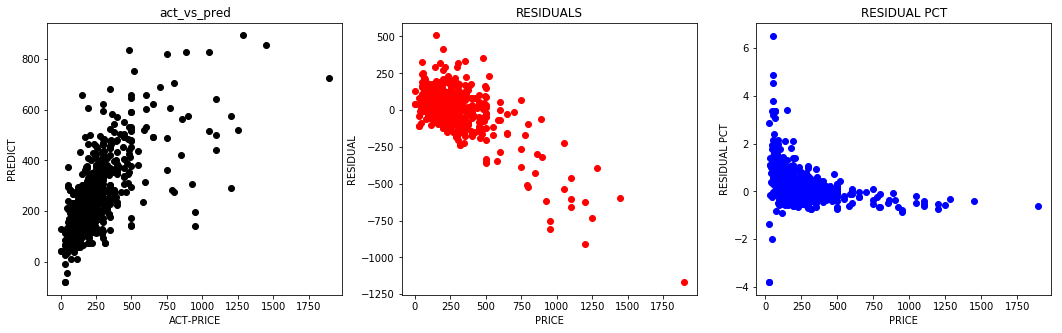

In [306]:
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_test, y_predsk,  color='black')
ax1.set_title('act_vs_pred')
ax1.set_xlabel('ACT-PRICE')
ax1.set_ylabel('PREDICT')

ax2.scatter(dfpred.price,dfpred.sk_resid, color='red')
ax2.set_title('RESIDUALS')
ax2.set_xlabel('PRICE')
ax2.set_ylabel('RESIDUAL')

ax3.scatter(dfpred.price,dfpred.sk_residpct, color='blue')
ax3.set_title('RESIDUAL PCT')
ax3.set_xlabel('PRICE')
ax3.set_ylabel('RESIDUAL PCT')

In [307]:
y_predsk

array([519.66430575, 264.69816537,  12.43088711,  93.73511581,
       194.57235444, 226.94148397, 151.21935045, 475.10739943,
       257.40196297, 115.36222619, 574.50952041, 132.0579389 ,
       137.0881198 , 199.50610754, 109.67973701, 279.53163504,
       290.64916184, 490.82715956, 159.63874285,  80.41992183,
       128.98048438, 233.83959213, 601.39939451, 420.33298641,
       240.89533696, 144.81658235, -45.01383951, 120.56109197,
       145.13095732, 230.00730982, 223.1750468 , 151.97417823,
       197.72606489,  96.50387885, 215.44463704,  81.85503948,
       171.70840365,  80.59129576, 215.44463704, 172.34511705,
       156.24953135, 171.10422246, 156.24953135, 149.4010034 ,
       160.08181366, 231.28673874, 836.11028557,  93.73511581,
       261.1086391 , 132.0579389 , 135.88526471, 317.85341091,
       232.89517753, 156.24953135, 468.40951807, 195.44060711,
       233.8512208 , 117.92670825, 197.58501106,  80.65714089,
       423.11306021, 232.89517753, 127.09629219, 194.57

In [308]:
y_test.head()

2162    587.0
4313    275.0
3889    115.0
1532    300.0
2498    250.0
Name: price, dtype: float64

In [309]:
print( y_train.shape, X_train.shape)

(3735,) (3735, 10)


In [310]:
import statsmodels.api as sm
import numpy as np
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     118.6
Date:                Tue, 07 Aug 2018   Prob (F-statistic):          2.29e-196
Time:                        00:17:59   Log-Likelihood:                -25899.
No. Observations:                3735   AIC:                         5.182e+04
Df Residuals:                    3725   BIC:                         5.188e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -19.1137 

507.7622156776299


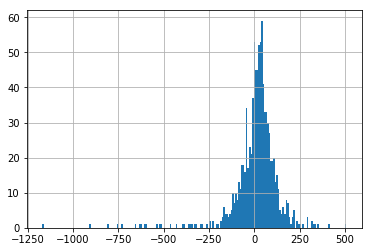

In [311]:
y_resdsk=(y_predsk-y_test)
print(y_resdsk.max())
y_resdsk.hist(bins =200)

12966.077424695268


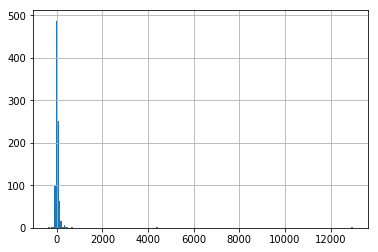

In [312]:
y_resdpct=(y_predsk-y_test)*100/(y_test+1)
print(y_resdpct.max())
y_resdpct.hist(bins =200)

In [313]:
dflreg.describe()

,const,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,min_night_stay_long,min_night_stay_mid,ppt_condensed_hostel,ppt_condensed_house
count,4669.0,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000
mean,1.0,3.339473,1.285821,1.390019,1.828015,217.754337,78.177982,0.005140,0.174984,0.012851,0.333690
std,0.0,1.995117,0.626862,0.940698,1.226746,264.990406,67.459155,0.071519,0.379994,0.112642,0.471581
min,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,2.000000,1.000000,1.000000,1.000000,100.000000,30.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,2.000000,1.000000,1.000000,1.000000,155.000000,65.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,4.000000,1.500000,2.000000,2.000000,250.000000,100.000000,0.000000,0.000000,0.000000,1.000000
max,1.0,16.000000,7.000000,7.000000,14.000000,9000.000000,700.000000,1.000000,1.000000,1.000000,1.000000


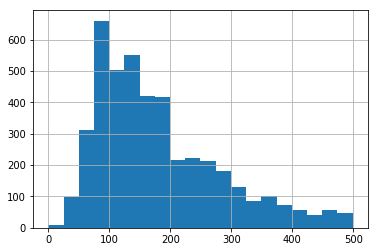

In [314]:
dflreg['price'][dflreg['price']<500].hist(bins=20);

In [315]:
# dflreg['price'][[dflreg['price']>500 & dflreg['price']<2000]].hist(bins=20);

In [316]:
pd.crosstab(dflreg['bedrooms'], dflreg['beds'])

beds,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0,14.0
bedrooms,,,,,,,,,,,,
0,5,317,128,8,3,0,0,0,0,0,0,0
1,30,2074,531,68,24,6,0,0,1,0,0,1
2,13,11,560,193,66,8,4,2,0,0,0,0
3,8,5,17,236,135,38,17,3,0,0,0,0
4,7,1,0,0,51,44,14,8,5,0,0,0
5,1,0,0,0,0,9,2,2,5,1,0,0
6,0,0,0,0,0,0,2,1,1,0,1,0
7,0,0,0,0,0,0,0,1,0,0,0,1


In [317]:
all_columns = X_train.columns
all_columns

Index(['const', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'cleaning_fee', 'min_night_stay_long', 'min_night_stay_mid',
       'ppt_condensed_hostel', 'ppt_condensed_house'],
      dtype='object')

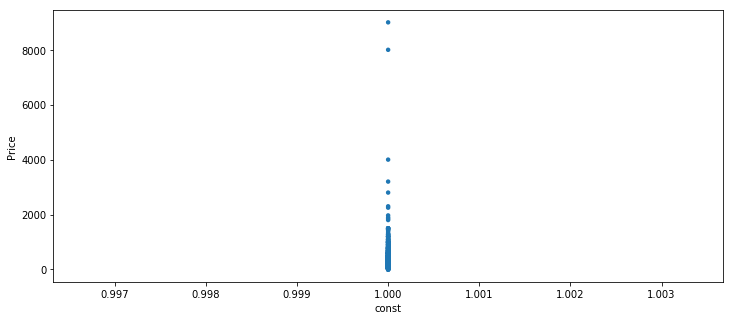

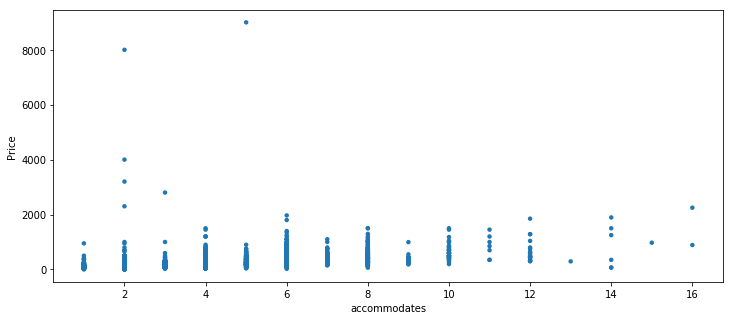

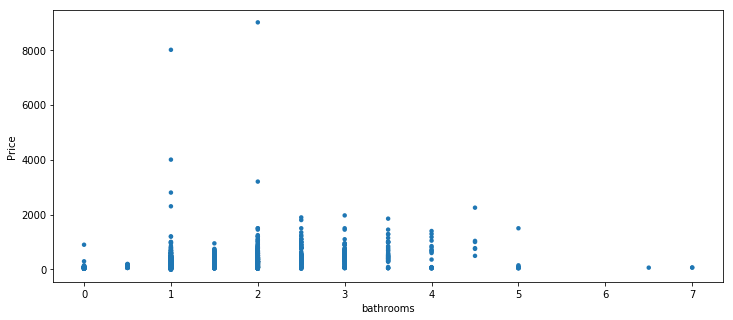

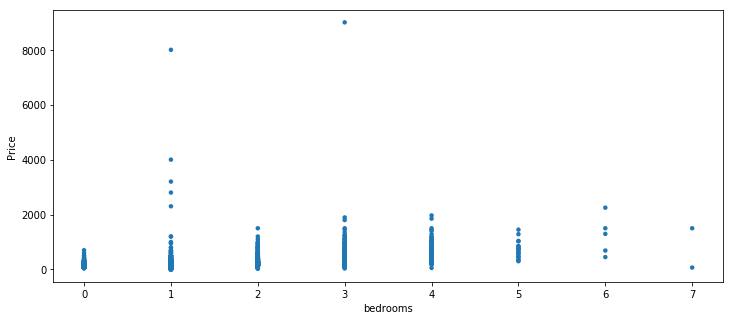

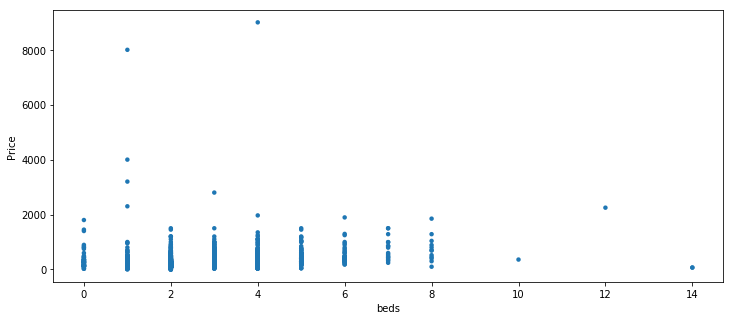

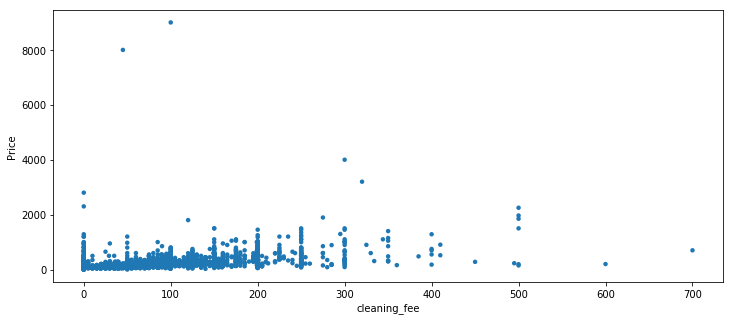

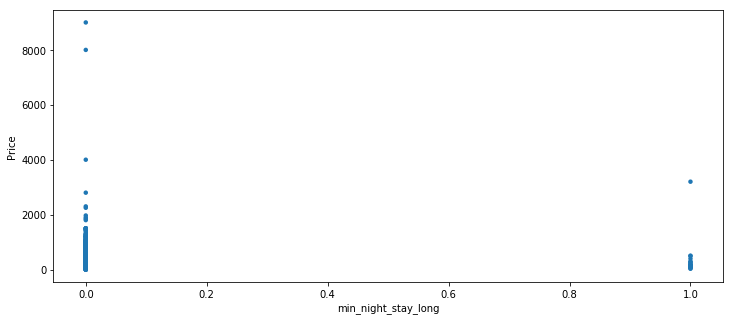

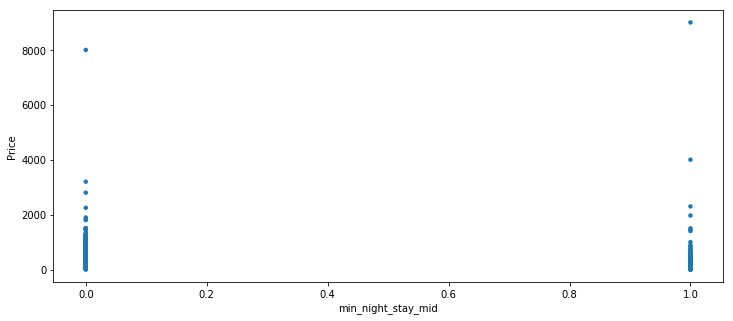

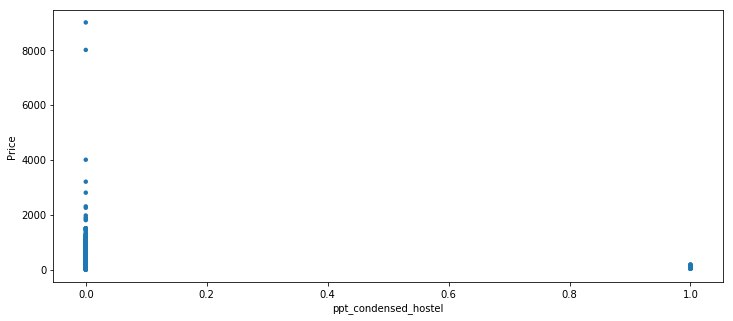

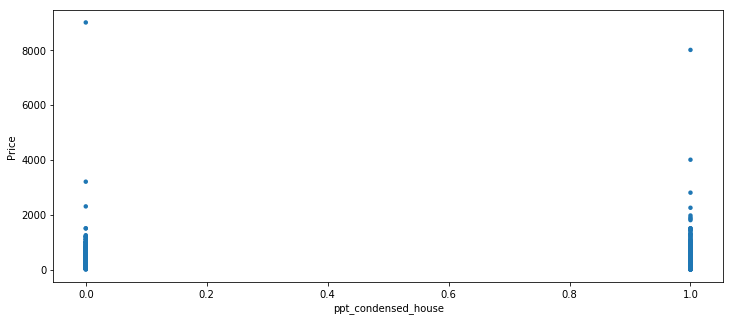

In [318]:
for col in all_columns:
    dfscat.plot(kind='scatter', y='price', x=col, edgecolor='none', figsize=(12, 5))
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()